In [1]:
# Import necessary libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from tqdm import tqdm

In [12]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append([img, filename])
    return images

def generate_sprite(image):
#     cropped_image, cropped_gray = autocrop(image[0])
    new_image = generate_cartoon(image[0])
    
    sprite = np.concatenate((new_image, image[0]), axis=1)
    cv2.imwrite( "output/"+image[1], sprite)

def generate_cartoon(image):
    # Apply some Gaussian blur on the image
    img_gb = cv2.GaussianBlur(image, (7, 7) ,0)
    # Apply some Median blur on the image
    img_mb = cv2.medianBlur(img_gb, 5)
    # Apply a bilateral filer on the image
    img_bf = cv2.bilateralFilter(img_mb, 5, 80, 80)

    # Use the laplace filter to detect edges
    img_lp_al = cv2.Laplacian(img_bf, cv2.CV_8U, ksize=5)

    # Convert the image to greyscale (1D)
    img_lp_al_grey = cv2.cvtColor(img_lp_al, cv2.COLOR_BGR2GRAY)

    # Remove some additional noise
    blur_al = cv2.GaussianBlur(img_lp_al_grey, (5, 5), 0)

    # Apply a threshold (Otsu)
    _, tresh_al = cv2.threshold(blur_al, 245, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert the black and the white
    inverted_Bilateral = cv2.subtract(255, tresh_al)

    # Reduce the colors of the original image
    div = 64
    img_bins = image // div * div + div // 2

    # Convert the mask image back to color
    inverted_Bilateral = cv2.cvtColor(inverted_Bilateral, cv2.COLOR_GRAY2RGB)
    # Combine the edge image and the binned image
    cartoon_Bilateral = cv2.bitwise_and(inverted_Bilateral, img_bins)
    return cartoon_Bilateral

def autocrop(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    coords = cv2.findNonZero(gray)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    rect = image[y:y+h, x:x+w] # Crop the image - note we do this on the original image
    gray_rect = gray[y:y+h, x:x+w]
    return [rect, gray_rect]

In [8]:
images = load_images_from_folder('val2017/')

In [13]:
for image in tqdm(images):  
    generate_sprite(image)

100%|██████████| 5000/5000 [03:22<00:00, 24.68it/s]


## Example

In [7]:
# Opens an image with cv2
img = cv2.imread('/Users/ioannapsylla/Downloads/photo.png')
generate_sprite(img)

In [ ]:
# Convert from BGR back to RGB
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gb_RGB = cv2.cvtColor(img_gb, cv2.COLOR_BGR2RGB)
img_mb_RGB = cv2.cvtColor(img_mb, cv2.COLOR_BGR2RGB)
img_bf_RGB = cv2.cvtColor(img_bf, cv2.COLOR_BGR2RGB)

# Plot the image to see some differences.
f, axarr = plt.subplots(2, 2, figsize=(25, 25))
axarr[0,0].imshow(img_RGB)
axarr[0,0].title.set_text('Original')
axarr[0,1].imshow(img_gb_RGB)
axarr[0,1].title.set_text('Original + GaussianBlur')
axarr[1,0].imshow(img_mb_RGB)
axarr[1,0].title.set_text('Original + GaussianBlur + MedianBlur')
axarr[1,1].imshow(img_bf_RGB)
axarr[1,1].title.set_text('Original + GaussianBlur + MedianBlur + BilaterFilter')

# Save the figure if needed
# plt.savefig('FilterComparisons.png')

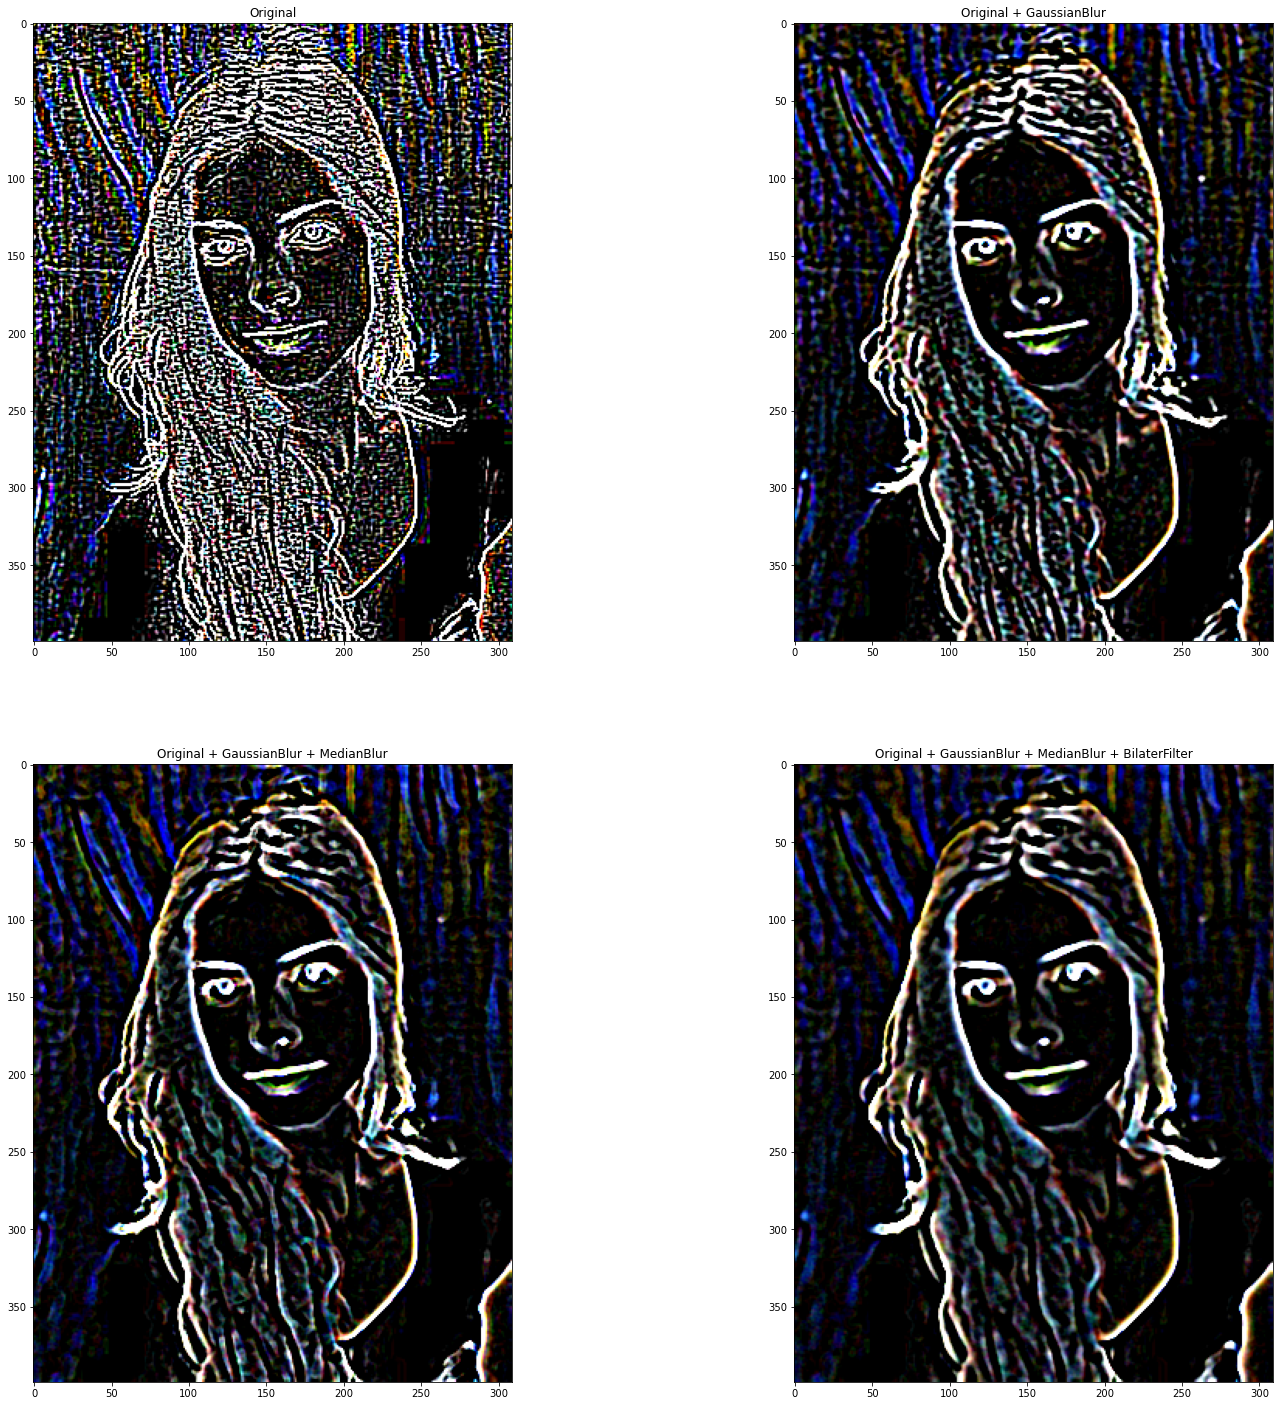

In [6]:
# Plot the image to see some differences.
f, axarr = plt.subplots(2,2, figsize=(25, 25))
axarr[0,0].imshow(img_lp_im, cmap='gray', vmin=0, vmax=255)
axarr[0,0].title.set_text('Original')
axarr[0,1].imshow(img_lp_gb, cmap='gray', vmin=0, vmax=255)
axarr[0,1].title.set_text('Original + GaussianBlur')
axarr[1,0].imshow(img_lp_mb, cmap='gray', vmin=0, vmax=255)
axarr[1,0].title.set_text('Original + GaussianBlur + MedianBlur')
axarr[1,1].imshow(img_lp_al, cmap='gray', vmin=0, vmax=255)
axarr[1,1].title.set_text('Original + GaussianBlur + MedianBlur + BilaterFilter')

# Save the figure if needed
# plt.savefig('LaplacianComparison.png')

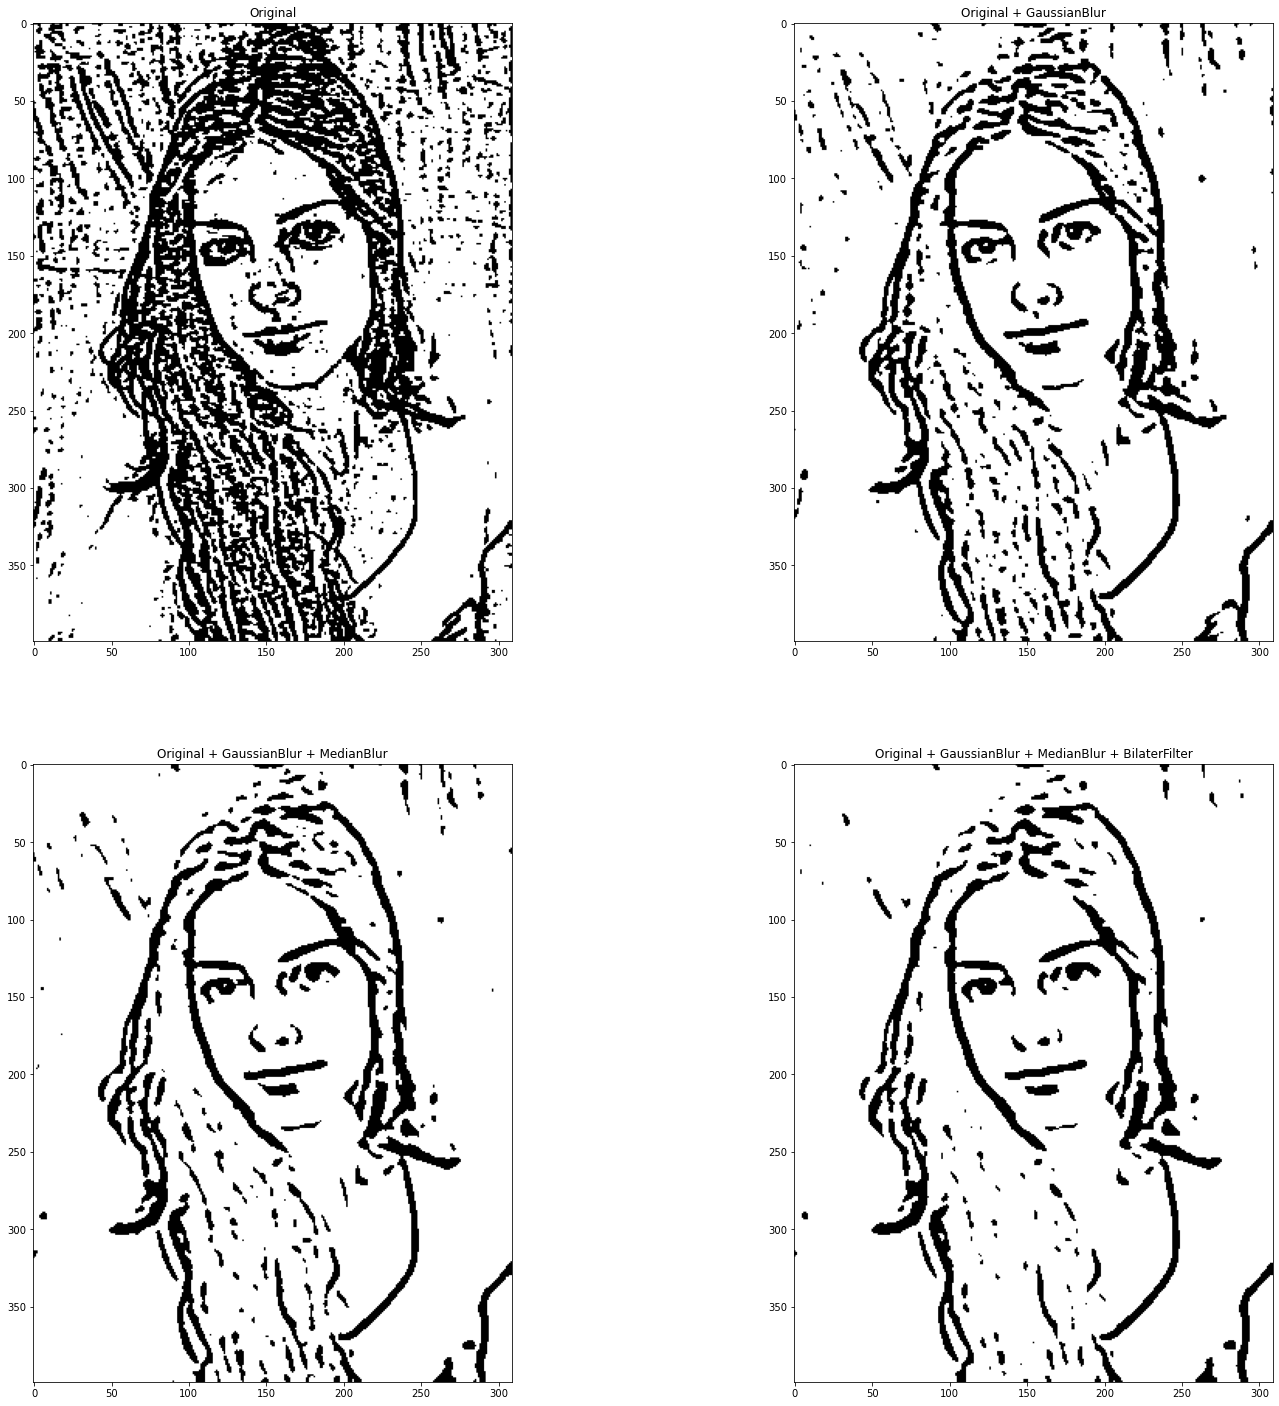

In [8]:
# Plot the image to see some differences.
f, axarr = plt.subplots(2,2, figsize=(25, 25))
axarr[0,0].imshow(inverted_original, cmap='gray', vmin=0, vmax=255)
axarr[0,0].title.set_text('Original')
axarr[0,1].imshow(inverted_GaussianBlur, cmap='gray', vmin=0, vmax=255)
axarr[0,1].title.set_text('Original + GaussianBlur')
axarr[1,0].imshow(inverted_MedianBlur, cmap='gray', vmin=0, vmax=255)
axarr[1,0].title.set_text('Original + GaussianBlur + MedianBlur')
axarr[1,1].imshow(inverted_Bilateral, cmap='gray', vmin=0, vmax=255)
axarr[1,1].title.set_text('Original + GaussianBlur + MedianBlur + BilaterFilter')

# Save the figure if needed
# plt.savefig('treshingComparison.png')

In [9]:
# Reduce the colors of the original image
div = 64
img_bins = img // div * div + div // 2

In [10]:
# Reshape the image
img_reshaped = img.reshape((-1,3))
# convert to np.float32
img_reshaped = np.float32(img_reshaped)
# Set the Kmeans criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# Set the amount of K (colors)
K = 8
# Apply Kmeans
_, label, center = cv2.kmeans(img_reshaped, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Covert it back to np.int8
center = np.uint8(center)
res = center[label.flatten()]
# Reshape it back to an image
img_Kmeans = res.reshape((img.shape))

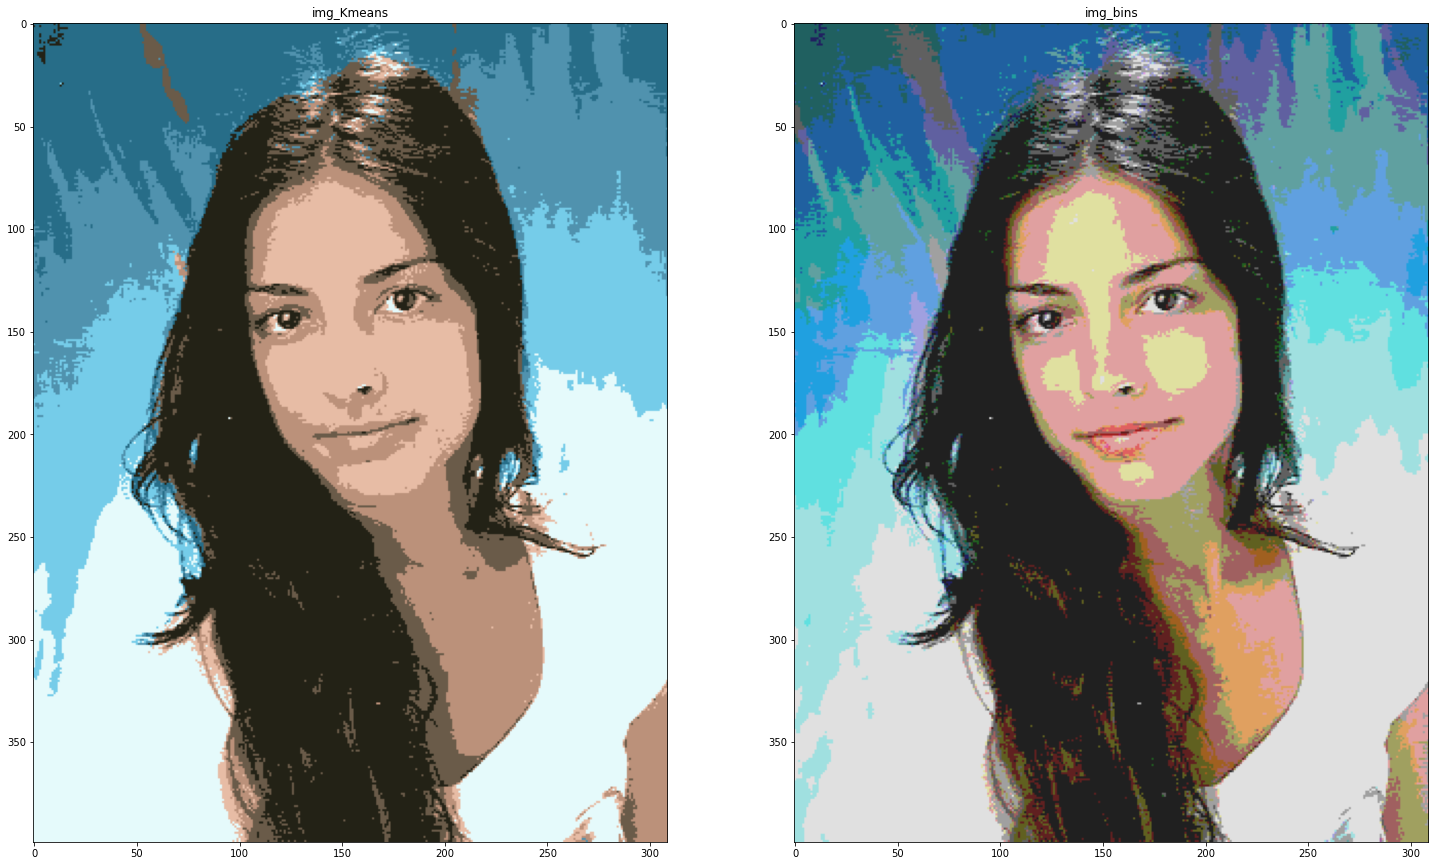

In [11]:
# Convert BGR back to RGB
img_Kmeans_RGB = cv2.cvtColor(img_Kmeans, cv2.COLOR_BGR2RGB)
img_bins_RGB = cv2.cvtColor(img_bins, cv2.COLOR_BGR2RGB)

# Plot the binned images to see  differences.
f, axarr = plt.subplots(1, 2, figsize=(25, 25))
axarr[0].imshow(img_Kmeans_RGB)
axarr[0].title.set_text('img_Kmeans')
axarr[1].imshow(img_bins_RGB)
axarr[1].title.set_text('img_bins')

# plt.savefig('colorReduce.png')